In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy.signal import convolve2d
from scipy.stats import norm

### test image

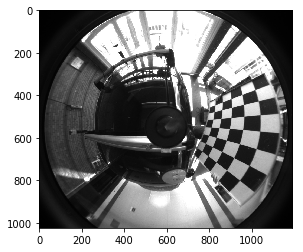

In [37]:
image = plt.imread('../data/01.png')
plt.imshow(image, cmap = 'gray')

## createCorrelationPatch.m
done

In [38]:
class Template:
    def __init__(self, height, width):
        self.a1 = np.zeros((height, width))
        self.b1 = np.zeros((height, width))
        self.a2 = np.zeros((height, width))
        self.b2 = np.zeros((height, width))
        
    def do_normalize(self):
        self.a1 = self.a1 / np.sum(self.a1)
        self.a2 = self.a2 / np.sum(self.a2)
        self.b1 = self.b1 / np.sum(self.b1)
        self.b2 = self.b2 / np.sum(self.b2)
        

def createCorrelationPatch(properties):
    angle_1, angle_2, radius = properties
    
    width  = radius*2 + 1
    height = radius*2 + 1
    
    # initialize template
    template = Template(height, width)
    
    # midpoint
    mu = radius + 1
    mv = radius + 1

    # compute normals from angles
    n1 = [-np.sin(angle_1), np.cos(angle_1)]
    n2 = [-np.sin(angle_2), np.cos(angle_2)]
    
    # for all points in template do
    for u in range(0, width):
        for v in range(0, height):
            # vector
            vec = [u-mu+1, v-mv+1]
            dist = np.linalg.norm(vec)
            
            # check on which side of the normals we are
            s1 = np.matmul(vec, np.transpose(n1))
            s2 = np.matmul(vec, np.transpose(n2))
            
            if (s1 <= -0.1 and s2 <= -0.1):
                template.a1[v][u] = norm.pdf(dist, 0, radius/2) # x, mu, sigma 
            elif (s1 >= 0.1 and s2 >= 0.1):
                template.a2[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 <= -0.1 and s2 >= 0.1):
                template.b1[v][u] = norm.pdf(dist, 0, radius/2) 
            elif (s1 >= 0.1 and s2 <= 0-.1):
                template.b2[v][u] = norm.pdf(dist, 0, radius/2)
                
    # normalize
    template.do_normalize()
    
    return template

## nonMaximumSuppression.m
maxima different

In [39]:
def nonMaximumSuppression(img, n, tau, margin):
    height, width = img.shape
    maxima = []
    for i in range(n+margin, width-n-margin, n+1):
        for j in range(n+margin, height-n-margin, n+1):
            # initial value
            maxi, maxj = i, j
            maxval = img[j][i]
            # update maxval if found
            for i2 in range(i, i+n):
                for j2 in range(j, j+n):
                    if (img[j2][i2] > maxval):
                        maxi, maxj = i2, j2
                        maxval = img[j2][i2]

            failed = 0
            for i2 in range(maxi-n, min(maxi+n, width-margin)):
                for j2 in range(maxj-n, min(maxj+n, height-margin)):
                    currval = img[j2][i2]
                    if (currval>maxval and (i2<i or i2>i+n or j2<j or j2>j+n)):
                        failed = 1
                        break
                if (failed):
                    break

            if (maxval >= tau and failed == 0):
                maxima.append([maxi, maxj])

    maxima = np.array(maxima)
    
    return maxima

## findCorners.m

In [40]:
def findCorners(img, tau):
    
    # filter image
    print('Start Filtering ...')
    
    # use 3 scales to obtain a modest level of scale invariance and robustness w.r.t blur
    radius = [4, 8, 12]

    # template properties     
    template_props = [[      0,  np.pi/2, radius[0]],
                      [np.pi/4, -np.pi/4, radius[0]],
                      [      0,  np.pi/2, radius[1]],
                      [np.pi/4, -np.pi/4, radius[1]],
                      [      0,  np.pi/2, radius[2]],
                      [np.pi/4, -np.pi/4, radius[2]]]
        
    img_corners = np.zeros(img.shape)
    for i in range(0, len(template_props)):
        # create correlation template
        template = createCorrelationPatch(template_props[i])
    
        # filter image according with current template
        img_corners_a1 = convolve2d(img, template.a1, 'same')
        img_corners_a2 = convolve2d(img, template.a2, 'same')
        img_corners_b1 = convolve2d(img, template.b1, 'same')
        img_corners_b2 = convolve2d(img, template.b2, 'same')
        
        # compute mean
        img_corners_mu = (img_corners_a1+img_corners_a2+img_corners_b1+img_corners_b2)/4
        # case 1: a=white, b=black
        img_corners_a = np.minimum(np.subtract(img_corners_a1, img_corners_mu), np.subtract(img_corners_a2, img_corners_mu))
        img_corners_b = np.minimum(np.subtract(img_corners_mu, img_corners_b1), np.subtract(img_corners_mu, img_corners_b2))
        img_corners_1 = np.minimum(img_corners_a, img_corners_b)
        
        # case 2: a=black, b=white
        img_corners_a = np.minimum(np.subtract(img_corners_mu, img_corners_a1), np.subtract(img_corners_mu, img_corners_a2))
        img_corners_b = np.minimum(np.subtract(img_corners_b1, img_corners_mu), np.subtract(img_corners_b2, img_corners_mu))
        img_corners_2 = np.minimum(img_corners_a, img_corners_b)
        
        # update corner map
        img_corners = np.maximum(img_corners, img_corners_1)
        img_corners = np.maximum(img_corners, img_corners_2)
        
    return img_corners

## compute image derivatives

In [41]:
def get_img_derivatives(img):
    
    # sobel masks
    du = [[-1,  0,  1],
          [-1,  0,  1],
          [-1,  0,  1]]
    
    dv = [[-1, -1, -1],
          [ 0,  0,  0],
          [ 1,  1,  1]]
    
    img_du = convolve2d(img, du, mode = 'same')
    img_dv = convolve2d(img, dv, mode = 'same')
    img_angle = np.arctan2(img_dv, img_du)
    img_weight = np.sqrt(img_du**2 + img_dv**2)
    
    # correct angle to lie in between [0,pi]
    h, w = img_angle.shape
    for i in range(0, h):
        for j in range(0, w):
            if(img_angle[i][j] < 0):
                img_angle[i][j] += np.pi
            elif(img_angle[i][j] > np.pi):
                img_angle[i][j] -= np.pi
    
    return img_du, img_dv, img_angle, img_weight

## refineCorners.m

In [59]:
class Corners:
    def __init__(self, NMS_corners):
        
        self.p = NMS_corners
        # init orientations to invalid (corner is invalid iff orientation=0)
        self.v1 = np.zeros(NMS_corners.shape)
        self.v2 = np.zeros(NMS_corners.shape)

In [ ]:
def refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, r):

    corners = Corners(NMS_corners)
    height, width = img_du.shape

    # for all corners do
    for i in range(0, len(corners.p)):
        # extract current corner location
        cu, cv = corners.p[i]
        
        # estimate edge orientations
        img_angle_sub  = img_angle[max(cv-r,1):min(cv+r,height), max(cu-r,1):min(cu+r,width)]
    
    
    return None

## findModesMeanShift.m

In [473]:
def findModesMeanShift(hist, sigma):
    # efficient mean-shift approximation by histogram smoothing
    
    # compute smoothed histogram
    hist_smoothed = np.zeros((len(hist)))
    for i in range(0, len(hist)):
        j = np.arange(-np.round(2*sigma), np.round(2*sigma)+1)
        idx = np.mod(i+j, len(hist))
        hist_smoothed[i] = np.sum(hist[idx] * norm.pdf(j, 0, sigma))

    modes = []
    # check if at least one entry is non-zero
    # (otherwise mode finding may run infinitly)
    if np.abs(hist_smoothed - hist_smoothed[0]).any() < 1e-5:
        return
    
    modes = np.empty((0, 2), float)
    # mode finding
    for i in range(0, len(hist_smoothed)):
        j = i
        while(1):
            j1 = np.mod(j+1, len(hist))
            j2 = np.mod(j-1, len(hist))
            h0 = hist_smoothed[j]
            h1 = hist_smoothed[j1]
            h2 = hist_smoothed[j2]
            if (h1 >= h0 and h1 >= h2):
                j = j1
            elif (h2 > h0 and h2 > h1):
                j = j2
                print(j)
            else:
                break

        if len(modes) == 0:
            modes = np.array([[j, hist_smoothed[j]]])
        elif (j not in modes[:,0]):    
            new = np.array([[j, hist_smoothed[j]]])
            modes = np.concatenate((modes, new))

    return modes, hist_smoothed

### refine corners

In [257]:
r = 10
corners = Corners(NMS_corners)
height, width = img_du.shape

# for all corners do
for i in range(0, len(corners.p)):
    # extract current corner location
    cu, cv = corners.p[i]

    # estimate edge orientations
    img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
    img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
    v1, v2 = edgeOrientations(img_angle_sub, img_weight_sub)

In [254]:
def edgeOrientations(img_angle, img_weight):
    # init v1 and v2
    v1 = [0, 0]
    v2 = [0, 0]
    
    # number of bins (histogram parameters)
    bin_num = 32
    
    # convert images to vectors
    vec_angle = img_angle.T.reshape(-1)
    vec_weight = img_weight.T.reshape(-1)
    
    # convert angles from normals to directions
    vec_angle = vec_angle + np.pi/2
    vec_angle[vec_angle > np.pi] -= np.pi
    
    #create histogram
    angle_hist = np.zeros((bin_num))
    for i in range(0, len(vec_angle)):
        bin = int(max(min(np.floor(vec_angle[i]/(np.pi/bin_num)),bin_num-1), 0))
        angle_hist[bin] = angle_hist[bin]+vec_weight[i];
    
    modes, angle_hist_smoothed = findModesMeanShift(angle_hist,1);
    
    
    
    return v1, v2

In [472]:
cu, cv = corners.p[0]
# estimate edge orientations
img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
vec_angle = (img_angle_sub.T).reshape(-1)
vec_angle = vec_angle + np.pi/2
vec_weight = img_weight_sub.T.reshape(-1)
vec_angle[vec_angle > np.pi] -= np.pi
bin_num = 32
angle_hist = np.zeros((bin_num))
for i in range(0, len(vec_angle)):
    bin = int(max(min(np.floor(vec_angle[i]/(np.pi/bin_num)),bin_num-1), 0))
    angle_hist[bin] = angle_hist[bin]+vec_weight[i];
    
    
sigma = 1
hist = angle_hist
hist_smoothed = np.zeros((len(hist)))
for i in range(0, len(hist)):
    j = np.arange(-np.round(2*sigma), np.round(2*sigma)+1)
    idx = np.mod(i+j, len(hist))
    hist_smoothed[i] = np.sum(hist[idx] * norm.pdf(j, 0, sigma))
    
modes = []
# check if at least one entry is non-zero
# (otherwise mode finding may run infinitly)
if np.abs(hist_smoothed - hist_smoothed[0]).any() < 1e-5:
    #return
    pass
modes = np.empty((0, 2), float)
# mode finding
for i in range(0, len(hist_smoothed)):
    j = i
    
    while(1):
        j1 = np.mod(j+1, len(hist))
        j2 = np.mod(j-1, len(hist))
        h0 = hist_smoothed[j]
        h1 = hist_smoothed[j1]
        h2 = hist_smoothed[j2]
        if (h1 >= h0 and h1 >= h2):
            j = j1
        elif (h2 > h0 and h2 > h1):
            j = j2
        else:
            break
    
    if len(modes) == 0:
        modes = np.array([[j, hist_smoothed[j]]])
    elif (j not in modes[:,0]):    
        new = np.array([[j, hist_smoothed[j]]])
        modes = np.concatenate((modes, new))

## demo.m

In [255]:
img = plt.imread('../data/01.png')

# normalize values between [0, 1]
img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# convert to grayscale image
if (len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# compute image derivatives
img_du, img_dv, img_angle, img_weight = get_img_derivatives(img)

# scale input image
img = (img - np.min(img))/(np.max(img) - np.min(img))

# find initial corners
initial_corners = findCorners(img, 0.01)

# extract corner candidates via non maximum suppressions
NMS_corners = nonMaximumSuppression(initial_corners, 3, 0.025, 5)

# subpixel refinement
refined_corners = refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, 10)

#chessboards = chessboardsFromCorners(refined_corners)
#plotChessboards(chessboards, refined_corners)


Start Filtering ...
(863, 2)


NameError: name 'refineCorners' is not defined

## for test

In [ ]:
image = plt.imread('../data/01.png')
initial_corners = findCorners(image, 0.01)
corners_p = nonMaximumSuppression(initial_corners, 3, 0.025, 5)

In [ ]:
img, n, tau, margin = img_corners, 3, 0.025, 5
height, width = img.shape
maxima = []
for i in range(n+margin, width-n-margin, n+1):
    for j in range(n+margin, height-n-margin, n+1):
        # initial value
        maxi, maxj = i, j
        maxval = img[j][i]
        # update maxval if found
        for i2 in range(i, i+n):
            for j2 in range(j, j+n):
                if (img[j2][i2] > maxval):
                    maxi, maxj = i2, j2
                    maxval = img[j2][i2]

        failed = 0
        for i2 in range(maxi-n, min(maxi+n, width-margin)):
            for j2 in range(maxj-n, min(maxj+n, height-margin)):
                currval = img[j2][i2]
                if (currval>maxval and (i2<i or i2>i+n or j2<j or j2>j+n)):
                    failed = 1
                    break
            if (failed):
                break
                    
        if (maxval >= tau and failed == 0):
            maxima.append([maxi, maxj])
            
maxima = np.array(maxima)        
print(maxima.shape)